In [1]:
import itk
import scipy
import skimage
import imageio
import matplotlib.pyplot as plt
import numpy as np
# %pylab inline

In [134]:
template = skimage.color.rgb2grey(imageio.imread('/Users/farid/Documents/Workspace/python/bactrace/data/samples/4_Pos_low Inflammation.tiff'))
sample_name = '6_Pos_Inflammation.tiff'
sample = skimage.color.rgb2grey(imageio.imread('/Users/farid/Documents/Workspace/python/bactrace/data/samples/' + sample_name))
# sample = skimage.color.rgb2grey(imageio.imread('/Users/farid/Documents/Workspace/python/bactrace/data/samples/3_Pos_Inflammation.tiff'))
# sample = skimage.color.rgb2grey(imageio.imread('/Users/farid/Documents/Workspace/python/bactrace/data/samples/5_Pos_low Inflammation.tiff'))
# sample = skimage.color.rgb2grey(imageio.imread('/Users/farid/Documents/Workspace/python/bactrace/data/samples/7_neg.tiff'))


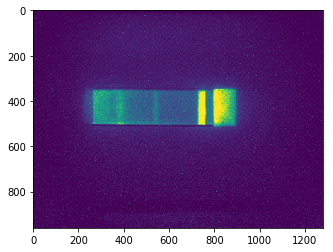

In [135]:
plt.imshow(template)

0 255


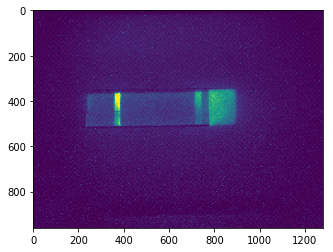

In [136]:
print(np.min(sample), np.max(sample))
plt.imshow(sample)

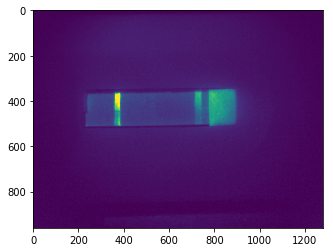

In [137]:
from scipy import ndimage
sample_med = ndimage.median_filter(sample, 5)
plt.imshow(sample_med)

In [138]:
from scipy import ndimage
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)

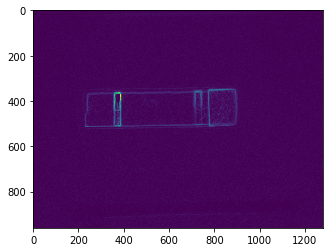

In [177]:
sample_blur = ndimage.gaussian_filter(sample_med, sigma=1)

(sample_sobel, theta) = sobel_filters(sample_blur.astype(np.float32))
plt.imshow(sample_sobel)

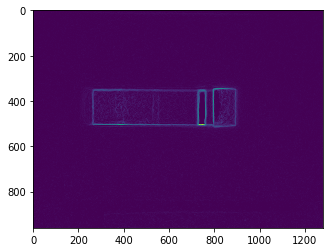

In [176]:
template_med = ndimage.median_filter(template, size=5)
template_blur = ndimage.gaussian_filter(template_med, sigma=1)

(template_sobel, theta) = sobel_filters(template_blur.astype(np.float32))
plt.imshow(template_sobel)

In [141]:
import SimpleITK as sitk

def command_iteration(method) :
    print("{0:3} = {1:7.5f} : {2}".format(method.GetOptimizerIteration(),
                                           method.GetMetricValue(),
                                           method.GetOptimizerPosition()))

In [148]:
fixed = sitk.GetImageFromArray(template_sobel)
fixed = sitk.Normalize(fixed)
fixed = sitk.DiscreteGaussian(fixed, 2.0)

In [149]:
moving = sitk.GetImageFromArray(sample_sobel)
moving = sitk.Normalize(moving)
moving = sitk.DiscreteGaussian(moving, 2.0)

In [150]:
R = sitk.ImageRegistrationMethod()

R.SetMetricAsJointHistogramMutualInformation()
# R.SetMetricAsCorrelation()

R.SetOptimizerAsGradientDescentLineSearch(learningRate=1.0,
                                          numberOfIterations=200,
                                          convergenceMinimumValue=1e-5,
                                          convergenceWindowSize=5)

In [151]:
R.SetInitialTransform(sitk.Euler2DTransform()) #fixed.GetDimension()

R.SetInterpolator(sitk.sitkLinear)

R.AddCommand( sitk.sitkIterationEvent, lambda: command_iteration(R) )

outTx = R.Execute(fixed, moving)

print("-------")
print(outTx)
print("Optimizer stop condition: {0}".format(R.GetOptimizerStopConditionDescription()))
print(" Iteration: {0}".format(R.GetOptimizerIteration()))
print(" Metric value: {0}".format(R.GetMetricValue()))

  0 = -0.05712 : (0.9686486155346489, 3.452883204535628e-05, 0.0018700912950538344)
  1 = -0.12691 : (1.9662837827833348, -0.0014476447196119955, 0.0029604485140317946)
  2 = -0.05098 : (1.9662837827833348, -0.0014476447196119955, 0.0029604485140317946)
  3 = -0.05098 : (1.9662837827833348, -0.0014476447196119955, 0.0029604485140317946)
-------
itk::simple::Transform
 Euler2DTransform (0x7f8c8ed364a0)
   RTTI typeinfo:   itk::Euler2DTransform<double>
   Reference Count: 2
   Modified Time: 299340
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     -0.385258 -0.922809 
     0.922809 -0.385258 
   Offset: [-0.00144764, 0.00296045]
   Center: [0, 0]
   Translation: [-0.00144764, 0.00296045]
   Inverse: 
     -0.385258 0.922809 
     -0.922809 -0.385258 
   Singular: 0
   Angle       = 1.96628

Optimizer stop condition: GradientDescentLineSearchOptimizerv4Template: Convergence checker passed at iteration 4.
 Iteration: 4
 Metric value: -0.12691305322330465


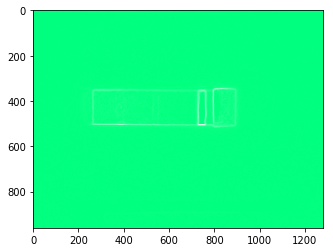

In [152]:
resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed);
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(1)
resampler.SetTransform(outTx)

out = resampler.Execute(moving)

simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
sample_registered = sitk.GetArrayFromImage(simg2)
cimg = sitk.Compose(simg1, simg2, simg1//2.+simg2//2.)
# sitk.Show( cimg, "ImageRegistration2 Composition" )
plt.imshow(sitk.GetArrayFromImage(cimg))

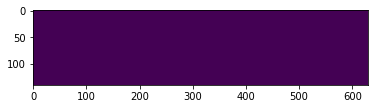

In [153]:
# cropping mask based on the template image
x1 = 270; x2 = 900; y1 = 360; y2 = 500

sample_cropped = sample_registered[y1:y2, x1:x2]
plt.imshow(sample_cropped)

In [94]:
import cv2

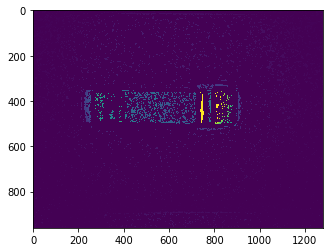

In [122]:
ret,thresh = cv2.threshold(template_sobel.astype(np.uint8),200,255,0)

contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

img = cv2.drawContours(template_med, contours, -1, (0,255,0), 3)
plt.imshow(img)

In [123]:
print(np.max(template_sobel))

255.0


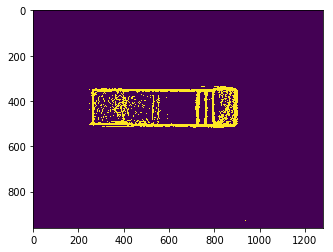

In [178]:
ret,thresh = cv2.threshold(template_sobel.astype(np.uint8),10,255,0)
plt.imshow(thresh)

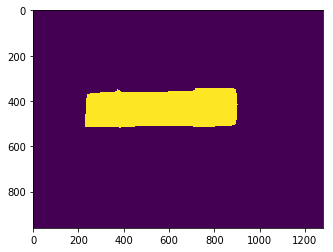

In [187]:
template_closed = ndimage.morphology.binary_closing(thresh, np.ones([100,100]), iterations=2)
plt.imshow(closed)

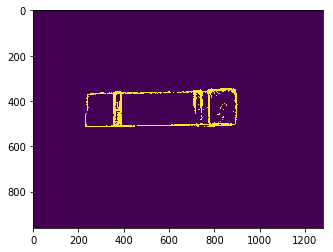

In [188]:
ret,thresh = cv2.threshold(sample_sobel.astype(np.uint8),20,255,0)
plt.imshow(thresh)

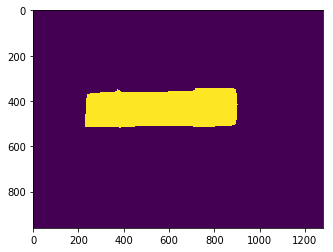

In [189]:
sample_closed = ndimage.morphology.binary_closing(thresh, np.ones([100,100]), iterations=2)
plt.imshow(closed)

In [191]:
fixed = sitk.GetImageFromArray(template_closed.astype(np.uint8))
fixed = sitk.Normalize(fixed)
fixed = sitk.DiscreteGaussian(fixed, 2.0)

In [192]:
moving = sitk.GetImageFromArray(sample_closed.astype(np.uint8))
moving = sitk.Normalize(moving)
moving = sitk.DiscreteGaussian(moving, 2.0)

In [193]:
R = sitk.ImageRegistrationMethod()

R.SetMetricAsJointHistogramMutualInformation()
# R.SetMetricAsCorrelation()

R.SetOptimizerAsGradientDescentLineSearch(learningRate=1.0,
                                          numberOfIterations=200,
                                          convergenceMinimumValue=1e-5,
                                          convergenceWindowSize=5)

In [194]:
R.SetInitialTransform(sitk.Euler2DTransform()) #fixed.GetDimension()

R.SetInterpolator(sitk.sitkLinear)

R.AddCommand( sitk.sitkIterationEvent, lambda: command_iteration(R) )

outTx = R.Execute(fixed, moving)

print("-------")
print(outTx)
print("Optimizer stop condition: {0}".format(R.GetOptimizerStopConditionDescription()))
print(" Iteration: {0}".format(R.GetOptimizerIteration()))
print(" Metric value: {0}".format(R.GetMetricValue()))

  0 = -0.47759 : (0.00023830533534849408, -6.29260484049113e-07, 1.5396217127922577e-06)
  1 = -0.47803 : (-0.0002359579577825374, -4.6029721935189776e-07, 9.027629271401008e-07)
  2 = -0.47804 : (0.000235789375941189, -6.007234959137039e-07, 1.571364602241713e-06)
  3 = -0.47804 : (-0.0002349001205903122, -4.3235149326408147e-07, 9.405034768478965e-07)
  4 = -0.47804 : (0.00023767117238222387, -5.730320887616089e-07, 1.6103001851270996e-06)
-------
itk::simple::Transform
 Euler2DTransform (0x7f8c8ffa2830)
   RTTI typeinfo:   itk::Euler2DTransform<double>
   Reference Count: 2
   Modified Time: 327035
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     1 -0.000235789 
     0.000235789 1 
   Offset: [-6.00723e-07, 1.57136e-06]
   Center: [0, 0]
   Translation: [-6.00723e-07, 1.57136e-06]
   Inverse: 
     1 0.000235789 
     -0.000235789 1 
   Singular: 0
   Angle       = 0.000235789

Optimizer stop condition: GradientDescentLineSearchOptimizerv4Template: Convergenc

In [198]:
fixed = sitk.GetImageFromArray(template_med)
fixed = sitk.Normalize(fixed)
fixed = sitk.DiscreteGaussian(fixed, 2.0)

In [199]:
moving = sitk.GetImageFromArray(sample_med)
moving = sitk.Normalize(moving)
moving = sitk.DiscreteGaussian(moving, 2.0)

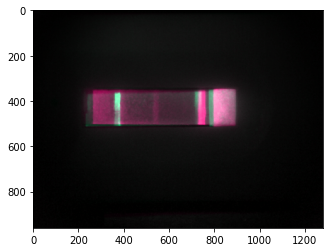

In [200]:

resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed);
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(1)
resampler.SetTransform(outTx)

out = resampler.Execute(moving)

simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
sample_registered = sitk.GetArrayFromImage(simg2)
cimg = sitk.Compose(simg1, simg2, simg1//2.+simg2//2.)
# sitk.Show( cimg, "ImageRegistration2 Composition" )
plt.imshow(sitk.GetArrayFromImage(cimg))

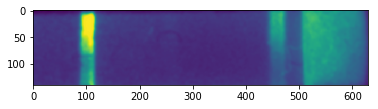

In [201]:
# cropping mask based on the template image
x1 = 270; x2 = 900; y1 = 360; y2 = 500

sample_cropped = sample_registered[y1:y2, x1:x2]
plt.imshow(sample_cropped)